In [1]:
from astroquery import sha
from astropy import coordinates as coord
from astropy import units as u
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
from astropy.visualization import quantity_support
from astropy.wcs import WCS
import numpy as np
from astropy.visualization import simple_norm
from astropy.nddata import Cutout2D
from reproject import reproject_interp
from matplotlib.patches import Circle
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion


/tmp/ipykernel_41458/3027866803.py:1: DeprecationWarning: the ``sha`` module has been moved to astroquery.ipac.irsa.sha, please update your imports.
  from astroquery import sha
/blue/adamginsburg/adamginsburg/repos/astroquery/astroquery/ipac/irsa/sha/__init__.py:14: UserWarning: Experimental: SHA has not yet been refactored to have its API match the rest of astroquery.
  warnings.warn("Experimental: SHA has not yet been refactored to have its "
fatal: detected dubious ownership in repository at '/blue/adamginsburg/adamginsburg/repos/dask'
To add an exception for this directory, call:

	git config --global --add safe.directory /blue/adamginsburg/adamginsburg/repos/dask


In [2]:
import requests
import re
import numpy as np
from astropy import table
import io
import time
from astropy import units as u
import radio_beam
import regions
from astropy.io import fits
from astropy.visualization import simple_norm
from astropy import stats, convolution, wcs, coordinates
from spectral_cube import SpectralCube
import pylab as pl
import spectral_cube
from spectral_cube import Projection,SpectralCube
import reproject

#from spectralindex import prefixes

import warnings
warnings.filterwarnings('ignore', category=spectral_cube.utils.StokesWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pl.matplotlib.cbook.MatplotlibDeprecationWarning)
np.seterr('ignore')

glimpses=g_subsets=['glimpsei_0_6', 'glimpseii_0_6', 'glimpse3d_0_6',
                    'glimpse360_0_6', 'glimpse_cygx_0_6',
                    'glimpse_deepglimpse_0_6', 'glimpse_smog_0_6',
                    'glimpse_velacar_0_6', 'mipsgal_images']

/tmp/ipykernel_41458/3013804130.py:24: MatplotlibDeprecationWarning: MatplotlibDeprecationWarning was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings('ignore', category=pl.matplotlib.cbook.MatplotlibDeprecationWarning)


## Spitzer

In [3]:
def get_spitzer_data(crd, size):
    files = {}
    for spitzertbl in glimpses:
        if 'glimpse' in spitzertbl:
            url = f"https://irsa.ipac.caltech.edu/IBE?table=spitzer.{spitzertbl}&POS={crd.ra.deg},{crd.dec.deg}&ct=csv&mcen&where=fname+like+'%.fits'"
        else:
            url = f"https://irsa.ipac.caltech.edu/IBE?table=spitzer.{spitzertbl}&POS={crd.ra.deg},{crd.dec.deg}&ct=csv&where=fname+like+'%.fits'"
        response = requests.get(url)
        response.raise_for_status()
        tbl = table.Table.read(io.BytesIO(response.content), format='ascii.csv')

        if (len(tbl) >= 4) and 'I1' not in files:
            fnames = tbl['fname']

            for fname in fnames:
                irsa_url = f"https://irsa.ipac.caltech.edu/ibe/data/spitzer/{spitzertbl}/{fname}?center={crd.ra.deg},{crd.dec.deg}&size={size.to(u.arcmin).value}arcmin"

                key = re.search("I[1-4]", fname).group()

                fh = fits.open(irsa_url)
                files[key] = fh
        elif 'mipsgal' in spitzertbl:
            fnames = tbl['fname']
            for fname in fnames:
                irsa_url = f"https://irsa.ipac.caltech.edu/ibe/data/spitzer/{spitzertbl}/{fname}?center={crd.ra.deg},{crd.dec.deg}&size={size.to(u.arcmin).value}arcmin"
                if 'mosaics24' in irsa_url and 'covg' not in irsa_url and 'mask' not in irsa_url and 'std' not in irsa_url:
                    fh = fits.open(irsa_url)
                    files['MG'] = fh
    return files


In [4]:
def show_contours_on_spitzer(fieldid, image, spitzerpath='spitzer_datapath',
                             spitzer_display_args=dict(stretch='log', min_percent=1, max_percent=99.99, clip=True),
                             mips=False,
                             figsize=(10,10),
                             color='orange',
                             zoom=None,
                             line=None,
                             contour_levels=None):
    """
    image should be Projection-like: should have .wcs.celestial
    """


    spitzfn = f'{spitzerpath}/{fieldid}_spitzer_images.fits'
    if mips:
        spitzfn = spitzfn.replace("spitzer", "mips")
    spitz = fits.open(spitzfn)[0]

    ww = wcs.WCS(spitz.header)

    fig = pl.figure(1, figsize=figsize)
    fig.clf()
    ax = fig.add_subplot(projection=ww.celestial)

    spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in spitz.data])

    ax.imshow(spitz_data.T.swapaxes(0,1))

    lims = ax.axis()


    if zoom:
        xdiff = lims[1] - lims[0]
        ydiff = lims[3] - lims[2]
        lims = (lims[0] + xdiff/zoom/2,
                lims[1] - xdiff/zoom/2,
                lims[2] + ydiff/zoom/2,
                lims[3] - ydiff/zoom/2)
    else:
        zoom = 1

    ax.contour(image, transform=ax.get_transform(image.wcs.celestial), levels=contour_levels, colors=[color], linewidths=[0.5])

    ax.axis(lims)
    ax.set_xlabel('Galactic Longitude')
    ax.set_ylabel('Galactic Latitude')

    txtpos = [0.97, 0.97]
    # xx,yy = ax.transData.inverted().transform(ax.transAxes.transform(txtpos))
    # arr = ax.images[0].get_array()
    # bgcolor = arr[int(xx)-2:int(xx)+2, int(yy)-2:int(yy)+2, :].mean(axis=(0,1))

    # #from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

    # #def complementary(r, g, b):
    # #    """returns RGB components of complementary color"""
    # #    hsv = rgb_to_hsv((r, g, b))
    # #    # force saturation to 1
    # #    return hsv_to_rgb(((hsv[0] + 0.5) % 1, 1, 1))

    # if np.any(bgcolor.mask) or bgcolor.mean() < 0.5:
    #     txcolor = 'white'
    # else:
    #     txcolor = 'black' #complementary(*bgcolor)
    txcolor = 'white'

    text = fieldid
    if line:
        text = f'{text}\n{line}'

    txt = ax.text(*txtpos, text, horizontalalignment='right',
                  #fontweight='bold',
                  color=txcolor,
                  fontsize=22,
                  verticalalignment='top', transform=ax.transAxes)

    #pl.figure(2).gca().imshow(image_b6.mask.include()[0])
    return fig


In [5]:
loc = '/orange/adamginsburg/cmz/g5/G5/sum/spw17_12CO/g5.mom0.smK.tot.12CO.spw17.im/'
# g5.12CO.spw17.im/
mom0_12CO = SpectralCube.read(loc, format='casa')#.with_spectral_unit(u.km / u.s, velocity_convention='radio')
cube = mom0_12CO

In [7]:
#cube = SpectralCube.read('/orange/adamginsburg/cmz/g5/G5/hopsdata/G5subim.im', format='casa').with_spectral_unit(u.km / u.second, velocity_convention='radio')


In [6]:
size = np.abs(np.max(cube.shape[1:] * cube.wcs.pixel_scale_matrix.diagonal()[:2])*u.deg)*1.5
center = coordinates.SkyCoord(*cube[0].world[int(cube.shape[1]/2), int(cube.shape[2]/2)][::-1],
                              frame=wcs.utils.wcs_to_celestial_frame(cube.wcs))
center = center.transform_to('fk5')


In [7]:
spitzer_data = get_spitzer_data(center, size)
assert 'I1' in spitzer_data
assert 'MG' in spitzer_data

In [8]:
spitzer_cube = np.array([spitzer_data['I4'][0].data, spitzer_data['I2'][0].data, spitzer_data['I1'][0].data, ])
#fits.PrimaryHDU(data=spitzer_cube, header=spitzer_data['I1'][0].header).writeto(spitzer_cubename, overwrite=True)

mipsdata,_ = reproject.reproject_interp(spitzer_data['MG'][0], spitzer_data['I1'][0].header)
mipsdata[np.isnan(mipsdata)] = np.nanmax(mipsdata)
mips_cube = np.array([mipsdata, spitzer_data['I4'][0].data, spitzer_data['I1'][0].data, ])
#fits.PrimaryHDU(data=mips_cube, header=spitzer_data['I1'][0].header).writeto(spitzer_cubename.replace("spitzer", "mips"), overwrite=True)


In [9]:
spitzer_data

{'I2': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2adb152d3ac0>],
 'I3': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2adb153bac70>],
 'I1': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2adb153d27f0>],
 'I4': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2adb153d28e0>],
 'MG': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2adb152e6d30>]}

In [10]:
'''def plot_spitz(spitz, image, contour_levels):
    spitz = spitz[0]
    ww = wcs.WCS(spitz.header)
    fig = pl.figure(1, figsize=(8,8))
    #fig.ckf()
    ax = fig.add_subplot(projection=ww.celestial)
    spitzer_display_args=dict(stretch='log', min_percent=1, max_percent=99.99, clip=True)
    spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in spitz.data])
    ax.imshow(spitz_data.T.swapaxes(0,1))
    lims = ax.axis()
    ax.contour(image, transform=ax.get_transform(image.wcs.celestial), levels=contour_levels, colors='white', linewidths=[1.5])
    ax.coords['glon'].set_axislabel('Galactic Longitude')
    ax.coords['glat'].set_axislabel('Galactic Latitude')

#for im in spitzer_data.items():
#    plot_spitz(im)
    #spitz = fits.open(im[1])[0]'''


"def plot_spitz(spitz, image, contour_levels):\n    spitz = spitz[0]\n    ww = wcs.WCS(spitz.header)\n    fig = pl.figure(1, figsize=(8,8))\n    #fig.ckf()\n    ax = fig.add_subplot(projection=ww.celestial)\n    spitzer_display_args=dict(stretch='log', min_percent=1, max_percent=99.99, clip=True)\n    spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in spitz.data])\n    ax.imshow(spitz_data.T.swapaxes(0,1))\n    lims = ax.axis()\n    ax.contour(image, transform=ax.get_transform(image.wcs.celestial), levels=contour_levels, colors='white', linewidths=[1.5])\n    ax.coords['glon'].set_axislabel('Galactic Longitude')\n    ax.coords['glat'].set_axislabel('Galactic Latitude')\n\n#for im in spitzer_data.items():\n#    plot_spitz(im)\n    #spitz = fits.open(im[1])[0]"

In [11]:
def plot_spitz(spitz, image, contour_levels):
    #spitz = spitz[0]
    ww = wcs.WCS(spitz.header)
    #print(ww.proj_plane_pixel_scales)
    fig = pl.figure(1, figsize=(8,8))
    #fig.ckf()
    ax = fig.add_subplot(projection=ww.celestial)
    spitzer_display_args=dict(stretch='linear', min_percent=7, max_percent=90., clip=True)
    #spitz_data = simple_norm(spitz.data, **spitzer_display_args)(spitz.data)
    spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in spitz.data])
    ax.imshow(spitz_data.T.swapaxes(0,1))
    lims = ax.axis()
    ax.contour(image, transform=ax.get_transform(image.wcs.celestial), levels=contour_levels, colors='white', linewidths=[1.5])
    ax.coords['glon'].set_axislabel('Galactic Longitude')
    ax.coords['glat'].set_axislabel('Galactic Latitude')
    
    #regi = regions.Regions.read('../G5/sum/spw17_12CO/ccc.reg')[0]
    #pixel_region = regi.to_pixel(wcs.WCS(spitz.header))
    #pixel_region.plot()


    
    return ax
    # (11.2681, -61.2931) (304.29243304, -55.81833393)
    
    
    #s = np.pi * (u.pixel_scale(u.pixel/15*u.arcsec))**2
    #s = np.pi*(15*u.arcsec)**2
    #print(WCS.proj_plane_pixel_scales(ww))
    #s = s.to(u.arcmin**2)
    #ax.scatter(304.29243304, -55.81833393, transform=ax.get_transform(image.wcs.celestial), s=s,
    #       edgecolor='cyan')#, facecolor='none')
    #print(s)
    # 15*u.arcsec
    #c = Circle((304.29243304, -55.81833393), 15*u.arcsec, edgecolor='yellow', facecolor='none',
     #      transform=ax.get_transform(image.wcs.celestial))
    #ax.add_patch(c)

In [12]:
regi = regions.Regions.read('/orange/adamginsburg/cmz/g5/G5/sum/spw17_12CO/ccc.reg')


In [13]:
regi[0]
from regions import PixCoord, RectanglePixelRegion
pixel_region = regi[0].to_pixel(ww)
pixel_region

NameError: name 'ww' is not defined

In [16]:
pixel_region.plot()
plt.xlim(right=300,left=-50)
plt.ylim(top=300,bottom=0)

NameError: name 'pixel_region' is not defined

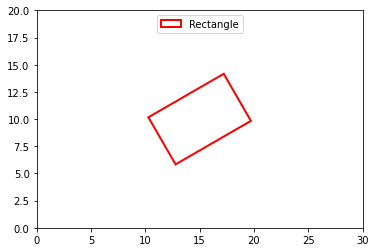

In [17]:
#pixel_region = reg[0].to_pixel(ww)
#patch = pixel_region.plot(facecolor='none', edgecolor='red',# lw=2,
#                 label='Rectangle')

#plt.legend(handles=(patch,), loc='upper center')
#plt.set_xlim(0, 30)
#plt.set_ylim(0, 20)
#plt.set_aspect('equal')
fig, ax = plt.subplots(1, 1)

reg = RectanglePixelRegion(PixCoord(x=15, y=10), width=8,
                           height=5, angle=Angle(30, 'deg'))
patch = reg.plot(ax=ax, facecolor='none', edgecolor='red', lw=2,
                 label='Rectangle')

ax.legend(handles=(patch,), loc='upper center')
ax.set_xlim(0, 30)
ax.set_ylim(0, 20)
ax.set_aspect('equal')

In [ ]:
'''loc1 = '/orange/adamginsburg/cmz/g5/G5/sum/spw17_12CO/g5.mom0.smK.tot.12CO.spw17.im/'
# g5.12CO.spw17.im/ # g5.mom0.smK.tot.12CO.spw17.im/
cube = SpectralCube.read(loc1, format='casa_image')
#pbv,_ = reproject.reproject_interp(pb[10].hdu, fh[0].header)

                # 10th channel is arbitrary but avoids edge channel
#data = fh[0].data * pbv
data = cube[0].hdu.data


m0 = Projection(data, wcs=wcs.WCS(cube[0].hdu.header))


std = stats.mad_std(data, ignore_nan=True)
levels = np.array([3, 5, 10, 20, 30])*std

m0 = Projection(data, wcs=wcs.WCS(cube[0].hdu.header))
contour_levels = np.logspace(0, 5, num=25)
    
plot_spitz(spitzer_data['I4'], m0, contour_levels)

#cube[0].hdu.data'''

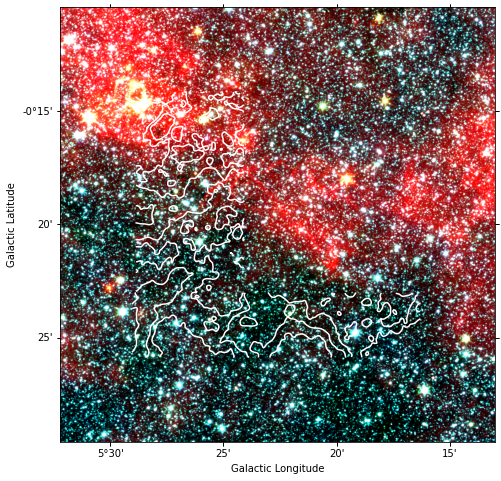

In [14]:
#loc1 = '/orange/adamginsburg/cmz/g5/G5/sum/spw31_C18O/g5.mom0.smK.tot.C18O.spw31.im'
#loc1 = '/orange/adamginsburg/cmz/g5/G5/sum/spw27_SiO/g5.mom0.smK.tot.SiO.spw27.im'
#loc1 = '/orange/adamginsburg/cmz/g5/G5/sum/spw25_H2CO/g5.mom0.smK.tot.H2CO.spw25.im'
loc1 = '/orange/adamginsburg/cmz/g5/G5/sum/newcombination/g5.H2CO.spw25.fits'
#'/orange/adamginsburg/cmz/g5/G5/sum/newcombination/g5.H2CO.spw25_test.fits'
plt.rcParams.update({'font.size': 16})

# H2CO or SiO or C18O
#loc1 = '/orange/adamginsburg/cmz/g5/G5/sum/spw17_12CO/g5.mom0.smK.tot.12CO.spw17.im/'
# g5.12CO.spw17.im/ # g5.mom0.smK.tot.12CO.spw17.im/
#cube = SpectralCube.read(loc1, format='casa_image')
cube = SpectralCube.read(loc1).with_spectral_unit(u.km/u.second, velocity_convention='radio')
#pbv,_ = reproject.reproject_interp(pb[10].hdu, fh[0].header)
#cube = SpectralCube.read('/orange/adamginsburg/cmz/g5/G5/hopsdata/G5subim.im', format='casa').with_spectral_unit(u.km / u.second, velocity_convention='radio')


                # 10th channel is arbitrary but avoids edge channel
#data = fh[0].data * pbv
data = cube.moment0().hdu.data
#data = cube[0].hdu.data

m0 = Projection(data, wcs=wcs.WCS(cube[0].hdu.header))


std = stats.mad_std(data, ignore_nan=True)
levels = np.array([3, 5, 10, 20, 30])*std
#levels = np.array([5, 10, 30])*std

m0 = Projection(data, wcs=wcs.WCS(cube[0].hdu.header))
contour_levels = np.logspace(0, 5, num=15)

spitz = fits.PrimaryHDU(data=[spitzer_data[filtername][0].data for filtername in ['I4','I2','I1']], header=spitzer_data['I4'][0].header)

ax1 = plot_spitz(spitz, m0, contour_levels)
plt.savefig('/orange/adamginsburg/cmz/g5/code/plots/alt_spitz.pdf',bbox_inches='tight')
plt.savefig('/orange/adamginsburg/cmz/g5/code/plots/alt_spitz.png',bbox_inches='tight')


#r = Quadrangle((5.392, -0.3313)*u.deg, 720*u.arcsec, 150*u.arcsec,
              # edgecolor='green', facecolor='none',
              # transform=ax.get_transform('galactic'))
#ax.add_patch(r)

#a = ICRS(Angle('00:21:38.6451 degrees'),Angle('-00:25:26.057 degrees'))

#ax.scatter(a[0],a[1], transform=ax.get_transform('icrs'), s=300,
 #          edgecolor='white', facecolor='purple')
#cor = SkyCoord('17:59:12', '-24:27:50', frame='icrs')

In [70]:
#cube.moment0()[0]#.quicklook()
contour_levels

array([1.00000000e+00, 2.27584593e+00, 5.17947468e+00, 1.17876863e+01,
       2.68269580e+01, 6.10540230e+01, 1.38949549e+02, 3.16227766e+02,
       7.19685673e+02, 1.63789371e+03, 3.72759372e+03, 8.48342898e+03,
       1.93069773e+04, 4.39397056e+04, 1.00000000e+05])

In [47]:
from astropy import units as u
from astropy.visualization.wcsaxes import Quadrangle
from astropy.coordinates import Angle
from astropy.coordinates import ICRS
from astropy.coordinates import SkyCoord

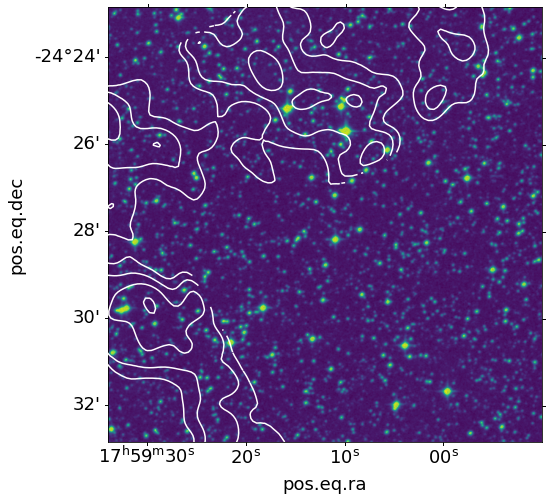

In [119]:
jsky = 'ALMA22/jsky13241953264208787586.fits'
hdul_t = fits.open(jsky)
im = hdul_t[0]
ww = wcs.WCS(im.header)
fig = pl.figure(1, figsize=(8,8))
ax = fig.add_subplot(projection=ww.celestial)
ax.imshow(im.data.T.swapaxes(0,1))
ax.contour(m0, transform=ax.get_transform(m0.wcs.celestial), levels=contour_levels, colors='white', linewidths=[1.5])

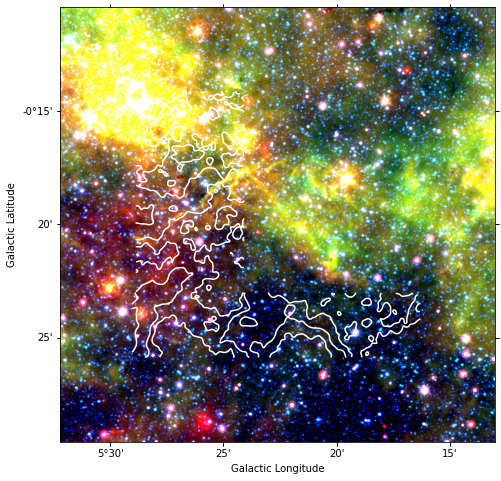

In [15]:
#cube[0].hdu.data
spitzer_data_2 = spitzer_data.copy()
spitzer_data_2['MG'] = [fits.PrimaryHDU(data=mipsdata, header=spitzer_data['I1'][0].header)]

spitz = fits.PrimaryHDU(data=[spitzer_data_2[filtername][0].data for filtername in ['MG','I4','I2']], header=spitzer_data['I4'][0].header)

ax2 = plot_spitz(spitz, m0, contour_levels)
plt.savefig('/orange/adamginsburg/cmz/g5/code/plots/spitzer_2.pdf',bbox_inches='tight')
plt.savefig('/orange/adamginsburg/cmz/g5/code/plots/spitzer_2.png',bbox_inches='tight')

In [93]:
##### SOFIA
s_url1 = 'https://irsa.ipac.caltech.edu/data/SOFIA/GREAT/OC1C/20130724_F120/raw/r2/data/si/GREAT1_1_03/008657_003_GREAT_SAFFTS1.fits' 
s_url2 = 'https://irsa.ipac.caltech.edu/data/SOFIA/GREAT/OC1C/20130724_F120/raw/r2/data/si/GREAT1_1_03/008657_003_GREAT_CPBE1.fits'
s_url3 = 'https://irsa.ipac.caltech.edu/data/SOFIA/GREAT/OC1C/20130724_F120/raw/r2/data/si/GREAT1_1_03/008657_003_GREAT_SXFFTS1.fits'

s_fits1 = fits.open(s_url1)
s_fits2 = fits.open(s_url2)
s_fits3 = fits.open(s_url3)

shead=s_fits2[0].header

In [94]:
c = coord.SkyCoord(ra=shead['OBSRA']*u.deg, dec=shead['OBSDEC']*u.deg, equinox=shead['TELEQUI'])

In [95]:
c.galactic

<SkyCoord (Galactic): (l, b) in deg
    (304.29243304, -55.81833393)>

In [96]:
#s_fits1[0].header

In [21]:
(1900536.9*u.MHz).to(u.THz)

<Quantity 1.9005369 THz>

In [22]:
15*u.arcsec

<Quantity 15. arcsec>

In [23]:
u.pixel_scale(u.pixel/15*u.arcsec)

[(Unit("pix"), Unit("15 / arcsec"))]

## Herschel

In [16]:
herfn_1 = '/orange/adamginsburg/higal/Field4_0_Combined_SPIRE_SpirePacsParallel_250_1342214761-1342214762_extd.fits'
herfn_2 = '/orange/adamginsburg/higal/Field4_0_Combined_SPIRE_SpirePacsParallel_350_1342214761-1342214762_extd.fits'
herfn_3 = '/orange/adamginsburg/higal/Field4_0_Combined_SPIRE_SpirePacsParallel_500_1342214761-1342214762_extd.fits'
pacsfn_1 = '/orange/adamginsburg/higal/Field4_0_PACS_SpirePacsParallel_160_1342214761-1342214762_jscanam.fits'
pacsfn_2 = '/orange/adamginsburg/higal/Field4_0_PACS_SpirePacsParallel_70_1342214761-1342214762_jscanam.fits'


In [17]:
her = fits.open(herfn_3)

In [18]:
type(her[0].data)

NoneType

In [19]:
#her[0].header

In [20]:

def plot_her(her, image, contour_levels):
    #spitz = spitz[0]
    ww = wcs.WCS(her[0].header)
    
    #ww = wcs.WCS(image.header)
    #print(ww.proj_plane_pixel_scales)
    fig = pl.figure(1, figsize=(8,8))
    #fig.ckf()
    ax = fig.add_subplot(projection=ww.celestial)
    spitzer_display_args=dict(stretch='asinh', min_percent=7, max_percent=90., clip=True)
    #spitz_data = simple_norm(spitz.data, **spitzer_display_args)(spitz.data)
    spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in her[1].data])
    ax.imshow(spitz_data.T.swapaxes(0,1))
    lims = ax.axis()
    ax.contour(image, transform=ax.get_transform(image.wcs.celestial), levels=contour_levels, colors='magenta', linewidths=[1.5])
    ax.coords['ra'].set_axislabel('Right Ascension')
    ax.coords['dec'].set_axislabel('Declination')
    
    c_icrs = coord.SkyCoord(ra=5.4*u.degree, dec=-0.4*u.degree, frame='icrs')
    
    #ax.scatter(304.29243304, -55.81833393, transform=ax.get_transform(image.wcs.celestial), s=s,
    #       edgecolor='cyan')
    ax.scatter(5.4, -0.4, transform=ax.get_transform('galactic'), s=300,
           edgecolor='white', facecolor='none')
    
    return ax
    #ax.coords['glon'].set_axislabel('Galactic Longitude')
    #ax.coords['glat'].set_axislabel('Galactic Latitude')


In [21]:
from astropy import stats, convolution, wcs, coordinates

loc1 = '/orange/adamginsburg/cmz/g5/G5/sum/spw17_12CO/g5.mom0.smK.tot.12CO.spw17.im/'
# g5.12CO.spw17.im/ # g5.mom0.smK.tot.12CO.spw17.im/
cube = SpectralCube.read(loc1, format='casa_image')
#pbv,_ = reproject.reproject_interp(pb[10].hdu, fh[0].header)

                # 10th channel is arbitrary but avoids edge channel
#data = fh[0].data * pbv
data = cube[0].hdu.data

std = stats.mad_std(data, ignore_nan=True)
levels = np.array([3, 5, 10, 20, 30])*std

m0 = Projection(data, wcs=wcs.WCS(cube[0].hdu.header))
contour_levels = np.logspace(0, 5, num=25)


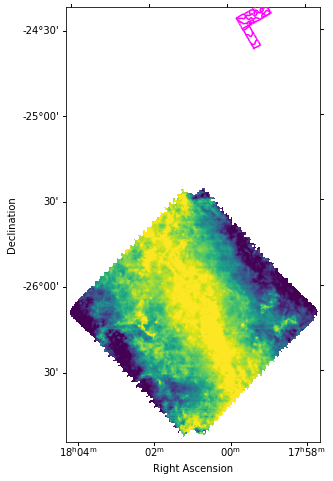

In [22]:
ax = plot_her(her, m0, contour_levels)

In [23]:
pos = (5.4*u.deg, -0.4*u.deg)
c_icrs = coord.SkyCoord(ra=5.4*u.degree, dec=-0.4*u.degree, frame='icrs')

In [24]:
from astropy import stats, convolution, wcs, coordinates

#wcs = wcs.WCS(her[0].header)
data = her[1].data

cutout = Cutout2D(data, c_icrs, (5, 5), wcs=wcs, mode='partial')
plt.imshow(cutout.data, origin='lower')

AttributeError: module 'astropy.wcs' has no attribute 'cpdis1'

In [25]:
pacs = fits.open(pacsfn_1)

In [26]:
plot_her(pacs, m0, contour_levels)

IndexError: index 0 is out of bounds for axis 1 with size 0

<Figure size 576x576 with 0 Axes>

In [27]:
loc_sio = '/orange/adamginsburg/cmz/g5/G5/sum/spw27_SiO/g5.mom0.smK.tot.SiO.spw27.im/'

sio = SpectralCube.read(loc_sio, format='casa_image')

sio.quicklook()

AttributeError: 'DaskSpectralCube' object has no attribute 'quicklook'

FileNotFoundError: [Errno 2] No such file or directory: 'plots/sio_m0.pdf'

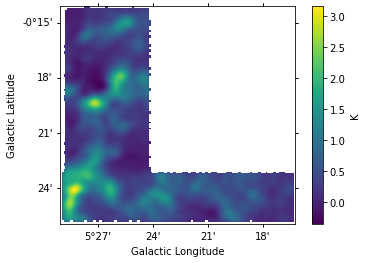

In [28]:
with quantity_support():
    plt.figure()
    ax = plt.subplot(111, projection=sio.wcs.celestial)
    plt.imshow(sio[0].value)
    cbar = plt.colorbar()
    cbar.set_label('K')
    ax.coords['glon'].set_axislabel('Galactic Longitude')
    ax.coords['glat'].set_axislabel('Galactic Latitude')
    plt.savefig('plots/sio_m0.pdf')

In [29]:
def plot_her(her, image, contour_levels):
    #spitz = spitz[0]
    ww = wcs.WCS(her.header)
    
    #ww = wcs.WCS(image.header)
    #print(ww.proj_plane_pixel_scales)
    fig = pl.figure(1, figsize=(8,8))
    #fig.ckf()
    ax = fig.add_subplot(projection=ww.celestial)
    spitzer_display_args=dict(stretch='asinh', min_percent=7, max_percent=99, clip=True)
    #spitz_data = simple_norm(her[1].data, **spitzer_display_args)(her[1].data)
    spitz_data = np.array([simple_norm(x, **spitzer_display_args)(x) for x in her.data])
    

    ax.imshow(spitz_data.T.swapaxes(0,1))
    lims = ax.axis()
    ax.contour(image, transform=ax.get_transform(image.wcs.celestial), levels=contour_levels, colors='w', linewidths=[1.5])
    #ax.coords['ra'].set_axislabel('Right Ascension')
    #ax.coords['dec'].set_axislabel('Declination')
    
    c_icrs = coord.SkyCoord(ra=5.4*u.degree, dec=-0.4*u.degree, frame='icrs')
    
    #ax.scatter(304.29243304, -55.81833393, transform=ax.get_transform(image.wcs.celestial), s=s,
    #       edgecolor='cyan')
    #ax.scatter(5.4, -0.4, transform=ax.get_transform('galactic'), s=300,
    #       edgecolor='white', facecolor='none')
    
    #reg = regions.RectangleSkyRegion(center=SkyCoord(5.378*u.deg, -0.408*u.deg, frame='galactic'), width=720*u.arcsec, height=150*u.arcsec, angle=0*u.deg)
    #preg = reg.to_pixel(wcs.WCS(spitz.header).celestial)
    #preg.plot(edgecolor='yellow')

    ax.coords['glon'].set_axislabel('Galactic Longitude')
    ax.coords['glat'].set_axislabel('Galactic Latitude')
    
    return ax


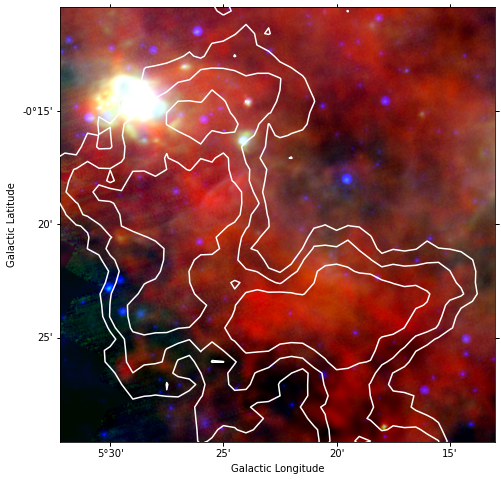

In [39]:
    #ax.coords['glon'].set_axislabel('Galactic Longitude')
    #ax.coords['glat'].set_axislabel('Galactic Latitude')
#ax = plot_her(her250hdu, m0, contour_levels)
#ax.axis([250,330,580,680])
#spitzer_cube = np.array([spitzer_data['I4'][0].data, spitzer_data['I2'][0].data, spitzer_data['I1'][0].data, ])
#fits.PrimaryHDU(data=spitzer_cube, header=spitzer_data['I1'][0].header).writeto(spitzer_cubename, overwrite=True)

cube = SpectralCube.read('/orange/adamginsburg/cmz/g5/G5/hopsdata/G5subim.im', format='casa').with_spectral_unit(u.km / u.second, velocity_convention='radio')
data = cube.moment0().hdu.data
#data = cube[0].hdu.data

m0 = Projection(data, wcs=wcs.WCS(cube[0].hdu.header))

her250 = fits.open(herfn_1)

her250data,_ = reproject.reproject_interp(her250[1], spitzer_data['I1'][0].header)
her250data[np.isnan(her250data)] = np.nanmax(her250data)

her70 = fits.open(pacsfn_2)

her70data,_ = reproject.reproject_interp(her70[1], spitzer_data['I1'][0].header)
her70data[np.isnan(her70data)] = np.nanmax(her70data)

her250_cube = np.array([her250data, her70data, mipsdata, ]) #spitzer_data['I4'][0].data])
her250hdu = fits.PrimaryHDU(data=her250_cube, header=spitzer_data['I1'][0].header)
#fits.PrimaryHDU(data=mips_cube, header=spitzer_data['I1'][0].header).writeto(spitzer_cubename.replace("spitzer", "mips"), overwrite=True)
ax = plot_her(her250hdu, m0, contour_levels[4:7])
#ax.axis([250,330,580,680])
plt.savefig('/orange/adamginsburg/cmz/g5/code/plots/her250_nh3.pdf',bbox_inches='tight')

In [59]:
contour_levels[4:7]

array([ 6.81292069, 11.00694171, 17.7827941 ])

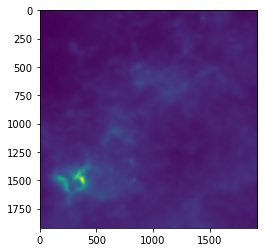

In [56]:
plt.imshow(her250hdu.data[0])

In [57]:
#loc1 = '/orange/adamginsburg/cmz/g5/G5/sum/spw17_12CO/g5.mom0.smK.tot.12CO.spw17.im/'
#cube = SpectralCube.read(loc1, format='casa_image')

In [58]:
loc1 = '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/baselineFixed/g5a.12CO.spw17.fits'
hdu_loc1 = fits.open(loc1)[0]
hdu_loc1.header['CTYPE1']
hdu_loc1.header['CTYPE2']

#cube = SpectralCube.read(loc1)

'DEC--SIN'

In [60]:
#CTYPE1  = 'GLON-SIN'           / galactic longitude, orthographic/synthesis proj
#CTYPE2  = 'GLAT-SIN'



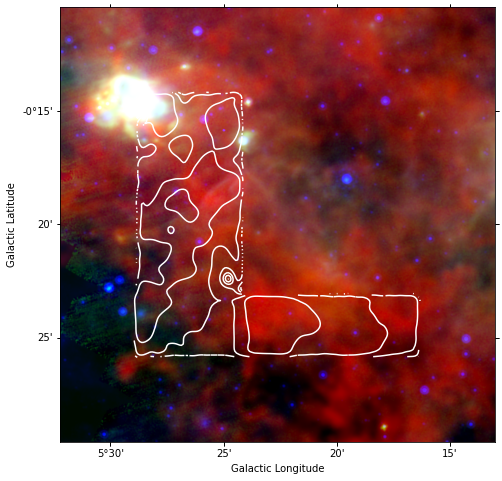

In [61]:
from astropy import stats, convolution, wcs, coordinates
# g5.12CO.spw17.im/ # g5.mom0.smK.tot.12CO.spw17.im/

#data = fh[0].data * pbv
data = cube[0].hdu.data

std = stats.mad_std(data, ignore_nan=True)
levels = np.array([3, 5, 10, 20, 30])*std

m0 = Projection(data, wcs=cube.wcs.celestial)
contour_levels = np.logspace(0, 5, num=25)
ax3 = plot_her(her250hdu, m0, contour_levels)
#ax.axis([250,330,580,680])

# SEDIGISM

In [41]:
S1_m0 = '/orange/adamginsburg/sedigism/sedigism/moments/G005_13CO21_SEDIGISM_DR1b_mom0.fits'
S2_m0 = '/orange/adamginsburg/sedigism/sedigism/moments/G005_13CO21_SEDIGISM_DR1c_mom0.fits'
S3_m1 = '/orange/adamginsburg/sedigism/sedigism/moments/G005_13CO21_SEDIGISM_DR1b_mom1.fits'
S4_m1 = '/orange/adamginsburg/sedigism/sedigism/moments/G005_13CO21_SEDIGISM_DR1c_mom1.fits'

In [42]:
S1_hdu = fits.open(S1_m0)
S2_hdu = fits.open(S2_m0)
S3_hdu = fits.open(S3_m1)
S4_hdu = fits.open(S4_m1)

In [43]:
S1_data = S1_hdu[0].data
S2_data = S2_hdu[0].data
S3_data = S3_hdu[0].data
S4_data = S4_hdu[0].data

In [44]:
s_ww = wcs.WCS(S1_hdu[0].header)
fig = pl.figure(1, figsize=(8,8))
ax = fig.add_subplot(projection=ww.celestial)
ax.imshow(S1_data.T.swapaxes(0,1))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')
#ax.coords['glon'].set_axislabel('Galactic Longitude')
#ax.coords['glat'].set_axislabel('Galactic Latitude')

NameError: name 'ww' is not defined

<Figure size 576x576 with 0 Axes>

In [66]:
S2_hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  775                                                  
NAXIS2  =                  397                                                  
DATAMIN = -0.1046435070038E+02         /                                        
DATAMAX =  0.3948420333862E+02         /                                        
BUNIT   = 'km s-1  '                                                            
OBJECT  = 'G5          '               /                                        
GLAT    =  0.5000000000000E+01         / Galactic latitude                      
GLON    =  0.0000000000000E+00         / Galactic longitude                     
EQUINOX =  0.2000000000000E+04         /                                        
LINE    = '13CO2-1     '    

In [45]:
sed1 = '/orange/adamginsburg/sedigism/sedigism/G005_13CO21_SEDIGISM_DR1b.fits'
sed2 = '/orange/adamginsburg/sedigism/sedigism/G005_13CO21_SEDIGISM_DR1c.fits'
#G005_masked0.5_lv.fits
#G005_masked0.5_lv_DR1c.fits
#G005_masked1_lv.fits
#G005_masked1_lv_DR1c.fits

sed1_hdu = fits.open(sed1)[0]
sed2_hdu = fits.open(sed2)[0]

In [46]:
sed1_cube = SpectralCube.read(sed1)
sed2_cube = SpectralCube.read(sed2)

In [47]:
sed1_mom0 = sed1_cube.moment(order=0)
sed2_mom0 = sed2_cube.moment(order=0)

INFO: Auto-setting vmin to -1.628e+04 [aplpy.core]
INFO: Auto-setting vmax to  6.382e+04 [aplpy.core]


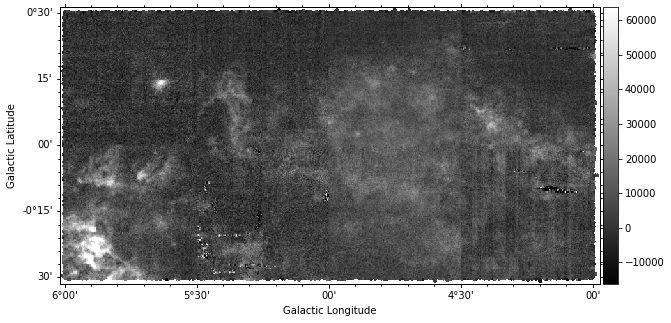

In [48]:
sed1_mom0.quicklook()

INFO: Auto-setting vmin to -1.852e+04 [aplpy.core]
INFO: Auto-setting vmax to  6.979e+04 [aplpy.core]


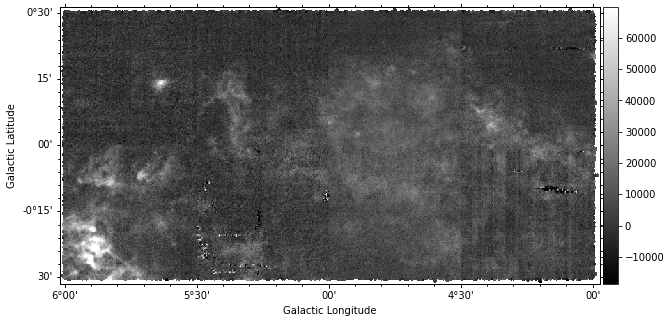

In [49]:
sed2_mom0.quicklook()

In [50]:
sed1_hdu.shape

(1, 1601, 397, 775)

In [51]:
#sed1_mom0_dat,_ = reproject.reproject_interp(sed1_hdu, spitzer_data['I1'][0].header)
#her250data[np.isnan(her250data)] = np.nanmax(her250data)

In [52]:
sed1m0_proj = sed1_mom0.reproject(spitzer_data['I1'][0].header)
sed2m0_proj = sed2_mom0.reproject(spitzer_data['I1'][0].header)

INFO: Auto-setting vmin to -3.334e+04 [aplpy.core]
INFO: Auto-setting vmax to  5.018e+04 [aplpy.core]


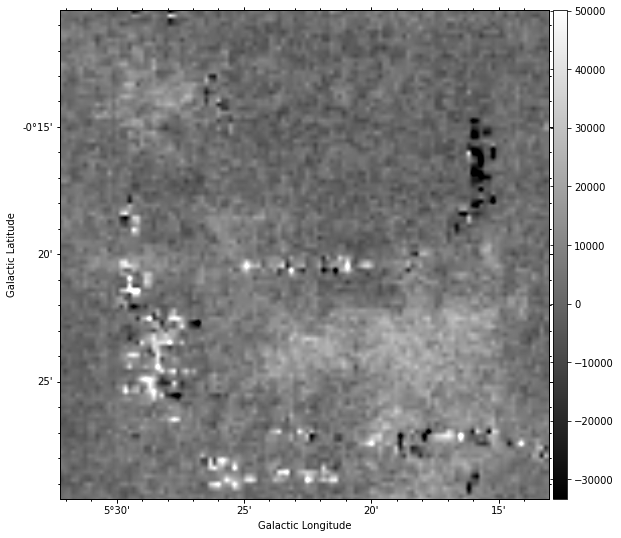

In [53]:
sed1m0_proj.quicklook()

INFO: Auto-setting vmin to -3.368e+04 [aplpy.core]
INFO: Auto-setting vmax to  5.155e+04 [aplpy.core]


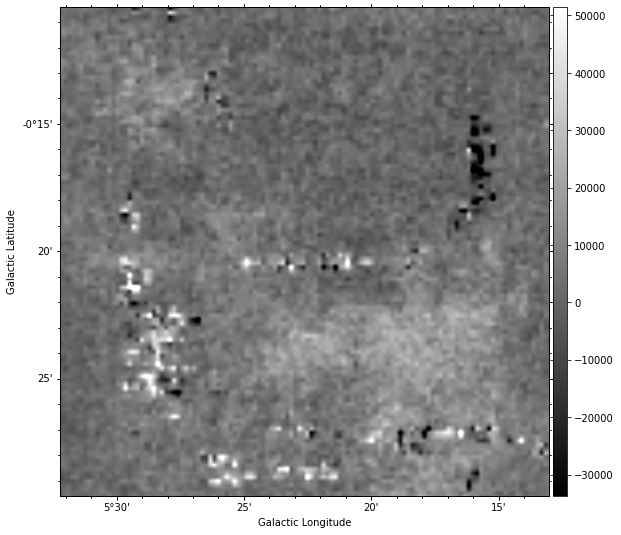

In [54]:
sed2m0_proj.quicklook()

In [55]:
ww = wcs.WCS(sed1m0_proj.header)

In [56]:
sed1m0_proj[np.isnan(sed1m0_proj)] = np.nanmax(sed1m0_proj)
sed1m0_proj[np.isnan(sed1m0_proj)] = np.nanmax(sed1m0_proj)


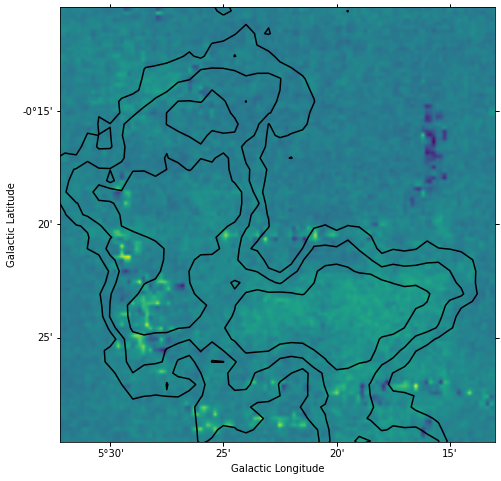

In [58]:
fig = pl.figure(1, figsize=(8,8))
ax = fig.add_subplot(projection=ww.celestial)
lims = ax.axis()
ax.contour(m0, transform=ax.get_transform(m0.wcs.celestial), levels=contour_levels[4:7], colors='black', linewidths=[1.5])

ax.imshow(sed2m0_proj.value)
ax.coords['glon'].set_axislabel('Galactic Longitude')
ax.coords['glat'].set_axislabel('Galactic Latitude')

In [80]:
norm = simple_norm(sed2m0_proj.data, 'asinh')
#im = ax.imshow(pvdiagram.data, norm=norm, cmap='afmhot')